In [61]:
# Miscellaneous
from functools import partial 
from ticktack import load_presaved_model

# Hamiltonian monte-carlo
from numpyro.infer import NUTS, MCMC

import jax.numpy as np
import jax.scipy as sc
import matplotlib.pyplot as plt
from jax import jit, jacrev, jacfwd, vmap, grad

In [62]:
cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()

In [63]:
@jit
def analytic_solution(parameters, time_out, /, fluxes=cbm._fluxes, 
    contents=cbm._reservoir_content, decay=cbm._decay_matrix):
    """
    This is the analytic solution itself.
    Parameters: 
        
    Returns:
    """
    start_date = parameters[0]
    event_area = parameters[1]

    trop_prod = parameters[2]   
    strat_prod = 1 - trop_prod  # Less degrees of freedom 
    production = zeros((11,))
    production = production.at[:2].set([strat_prod, trop_prod])

    weights = ones(11, dtype=float64)
    weights = weights.at[0].set(parameters[3])  # Less degrees of freedom 
    weights = weights.at[2:].set(parameters[4:])

    # Constructs the transfer matrix 
    c_14_fluxes = fluxes / np.transpose(weights * contents)
    new_c_14_fluxes = np.diag(np.sum(c_14_fluxes, axis=1))
    transfer_matrix = np.transpose(c_14_fluxes) - new_c_14_fluxes - decay
    initial_position = event_area * production

    @jit
    @vmap
    def vmap_util(t, /, transfer_matrix=transfer_matrix, y0=initial_position, start=start_date):
        # Try vmap expm directly
        return sc.linalg.expm((t - start) * transfer_matrix) @ y0

    impulse_solution = vmap_util(time_out)
    steady_solution = np.zeros((impulse_solution.shape))
    condition = (time_out > start_date).reshape(-1, 1)
    
    return np.where(condition, impulse_solution, steady_solution)

In [6]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        header = next(data)
        data = array([row.strip().split(" ") for row in data], dtype=float64)
        return data.T


In [7]:
data = load("miyake12.csv")
data = data.at[1].add(-mean(data[1, 1:4]))

In [50]:
@partial(jit, static_argnums=(1, 2))
def loss(parameters, /, analytic_solution=analytic_solution, data=data):
    in_bounds = np.any((parameters[2:] < 0.0) | (parameters[2:] > 1.0)) * -np.inf
    analytic_data = analytic_solution(parameters, data[0])
    chi_sq = vsum((data[1] - analytic_data[:, 1]) ** 2 / data[2] ** 2)
    return in_bounds + chi_sq

In [64]:
parameters = np.array([774.86, 40.0, 1.3, *[1.0 for _ in range(10)]])
time_out = np.arange(770, 790)

In [57]:
gradient = jit(grad(loss))
hessian = jit(jacfwd(jacrev(loss)))

In [43]:
# Running the No U Turn sampling
nuts_kernel = NUTS(potential_fn=loss)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=True)
mcmc.run(PRNGKey(11), init_params=parameters)

sample: 100%|██████████| 600/600 [00:13<00:00, 45.73it/s, 1 steps of size 1.43e-64. acc. prob=0.00] 


In [44]:
test = mcmc.get_samples()

In [45]:
import seaborn as sns
sns.set()

/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_sin

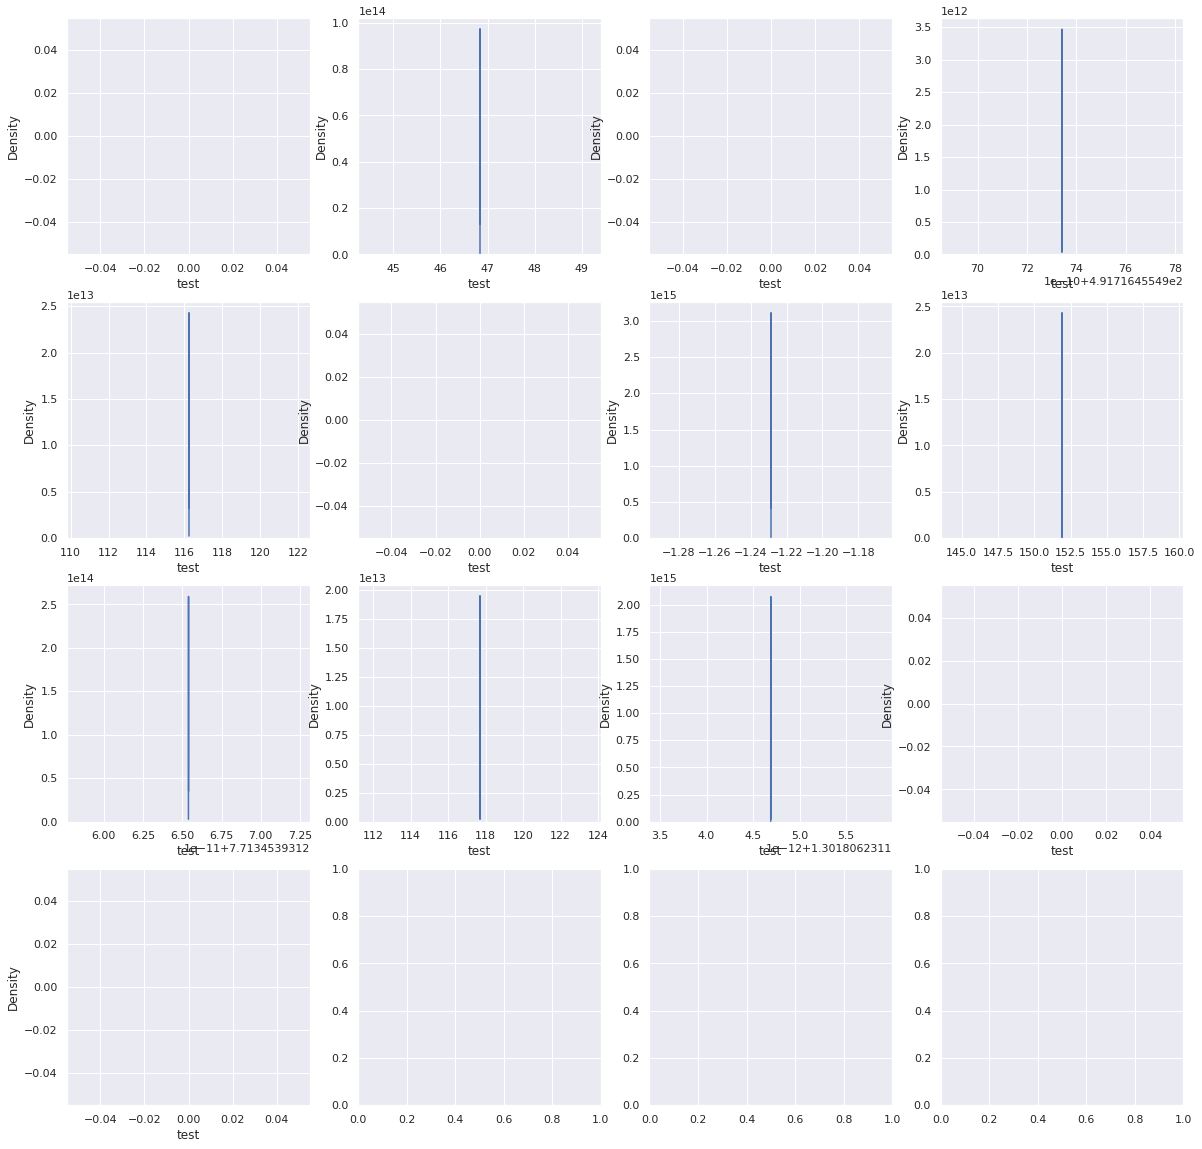

In [46]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for index, variable in enumerate(test.T):
    axis = axes[index // 4][index % 4]
    sns.kdeplot(test.T[index], ax=axis)
    axis.set_xlabel("test")